### RFC

### import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [2]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats
%store -r best_feats_ranks
%store -r X_test_labeled_df



### configurations
* save_plots -> True|False
* random_seed_state -> number, sets random state for model and for stratified splits 
* classify_bedrock_only -> True|False
* pickle_model -> True|False, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> True|False, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string,  filepath for serialised model to be saved to

In [3]:
save_plots = True
random_seed_state = 42
classify_bedrock_only = False
grid_search = False
scale = False
save_predictions = True

### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

In [4]:
if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### counts of instances in all classes before oversampling

In [5]:
train_data_formodel['class'].value_counts()

22    120
4     105
23    105
16    100
21     74
17     61
24     60
0      53
12     45
14     36
2      36
15     36
6      30
11     30
10     30
7      30
20     28
5      27
8      27
19     27
1      24
13     21
3      18
18     18
9      17
Name: class, dtype: int64

### The class column is stored as the variable y 

In [6]:
y = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [7]:
train_data_feats = train_data_formodel[best_feats]

In [8]:
best_feats_ranks

['Cr52',
 'B11',
 'S33',
 'U238',
 'Ca42',
 'Mg24',
 'Zr90',
 'Sc45',
 'Rb85',
 'P31',
 'V51',
 'Ge72',
 'Sr88',
 'Ba137',
 'Fe56',
 'Al27',
 'Li7',
 'Mn55',
 'La139',
 'Ce140',
 'Si28',
 'Nd146',
 'Ga69',
 'Pr141',
 'Ni60',
 'K39',
 'Cu63',
 'As75',
 'Nb93',
 'Pb208',
 'Cd111',
 'Sm147',
 'Y89',
 'Zn68',
 'Ti47',
 'Co59',
 'Sn118',
 'Yb172',
 'Cs133',
 'Dy163']

### address class imbalance using synthetic minority oversampling technique (SMOTE) algorithm

In [9]:
if scale:
    my_scaler = StandardScaler()
    X = np.array(my_scaler.fit_transform(np.array(train_data_feats)))
else:
    X = np.array(np.array(train_data_feats))

### the dimensions of the class and features are checked

In [10]:
print(X.shape)
print(y.shape)

(1158, 16)
(1158,)


### Gri dsearch is done to identify best hyperparamaters for the model

In [11]:
%%time
if grid_search:
    esti = RandomForestClassifier()


    
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    min_samples_split = [2, 5, 10, 15]
    min_samples_leaf = [1, 2, 4, 8]
    bootstrap = [True, False]
    
    
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    clf = RandomizedSearchCV(estimator = esti, n_iter=200, param_distributions = random_grid,
                              n_jobs=-1, scoring='f1_macro', cv = 3, verbose=3, 
                              random_state = random_seed_state)
    
    clf.fit(X, y)
    print(clf.best_params_)
    mistake

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


The best paramaters from the randomised grid search were the following:
{'n_estimators': 1755, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}

randomised grid search took ~18 mins for 600 fits

In [12]:
%%time
if grid_search:
    esti = RandomForestClassifier(bootstrap = True, max_features = 'auto')

    n_estimators = [1600, 1700, 1800]
    max_depth = [80, 100, 120]
    min_samples_split = [2, 3, 4]
    min_samples_leaf = [1, 2, 3]
    
    
    random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                  }
    
    clf = GridSearchCV(estimator = esti, param_grid= random_grid,
                              n_jobs=-1, scoring='f1_macro', cv = 3, verbose=3)
    clf.fit(X, y)
    print(clf.best_params_)
    mistake

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


Best paramters identified by gridsearch were:
{'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1700}

so final best paramaters are

{'n_estimators': 1700 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}

it took  7 mins for 243 fits

### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores with weighted averages are calculated

In [13]:
esti = RandomForestClassifier(n_estimators=1700, random_state = random_seed_state, n_jobs=-1, 
                              min_samples_split =  3, min_samples_leaf = 1, max_features = 'auto', 
                              max_depth = 100, bootstrap =  True)
skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
skf.get_n_splits(X, y)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
feat_imp_dict = {}
count = 0
for train_index, test_index in skf.split(X, y):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)
    
    esti.fit(X_post_smote, y_post_smote)

    y_pred = esti.predict(X_test)
    class_f1_scores = f1_score(y_test, y_pred, average = None)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    feat_imp_dict[key] = esti.feature_importances_

making model:
1
making model:
2
making model:
3
making model:
4


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
5
making model:
6


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
7


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
8
making model:
9
making model:
10


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
f1_df = pd.DataFrame(data = f1_dict)


In [15]:
for key in f1_dict:
    print(len(f1_dict[key]))

25
25
25
25
25
25
25
25
25
25


### Below are the encodings for the class variable

In [16]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
['FH', 'ER', 'WW', 'TC', 'CS', 'KQ', 'AR', 'SL', 'FG', 'WB', 'BX', 'PF', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', 'AB', 'LV', 'SE', 'BA', 'SV', 'WA', 'MM']


In [17]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [18]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

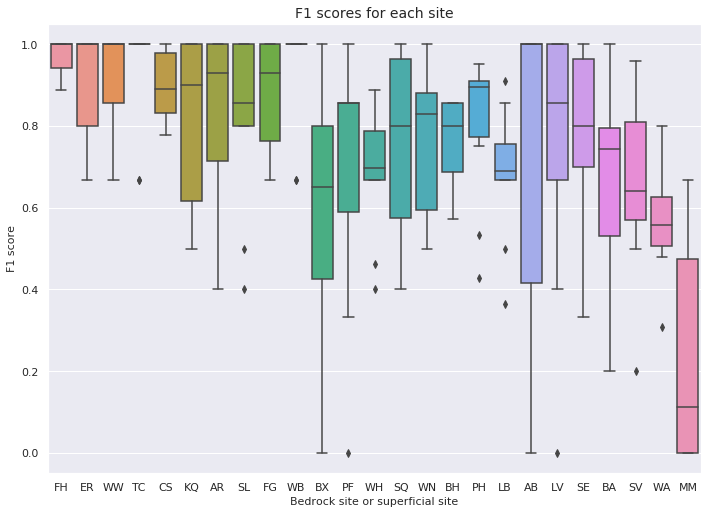

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial site", fontdict={'fontsize': 11})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('site_specific_f1_scores.png')

In [21]:
if save_plots:
    pd.DataFrame(data = f1_df_final.T.median()).to_csv('median_class_f1_scores.csv')

### Boxplot showing the macro F1 score with weighted averages

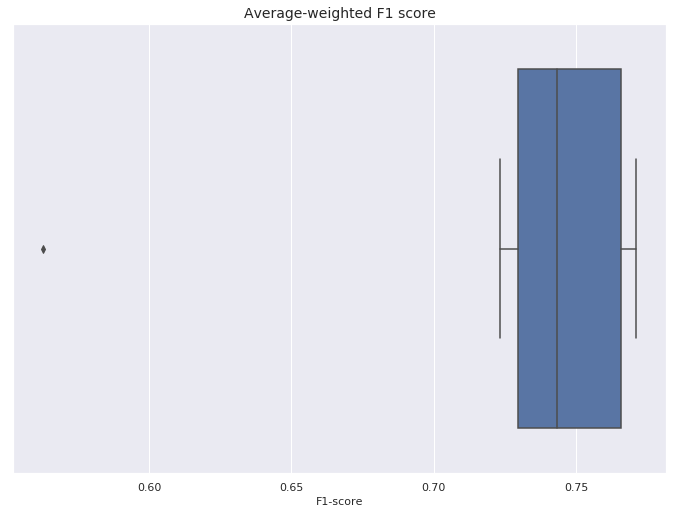

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted F1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('average-weighted f1_scores.png')

In [23]:
if save_plots:
    pd.Series(pd.Series(macro_f1_scores).median()).to_csv('median_macro_f1.csv')

In [24]:
pd.Series(macro_f1_scores).median()

0.7434640604741296

### Boxplot showing accuracy scores

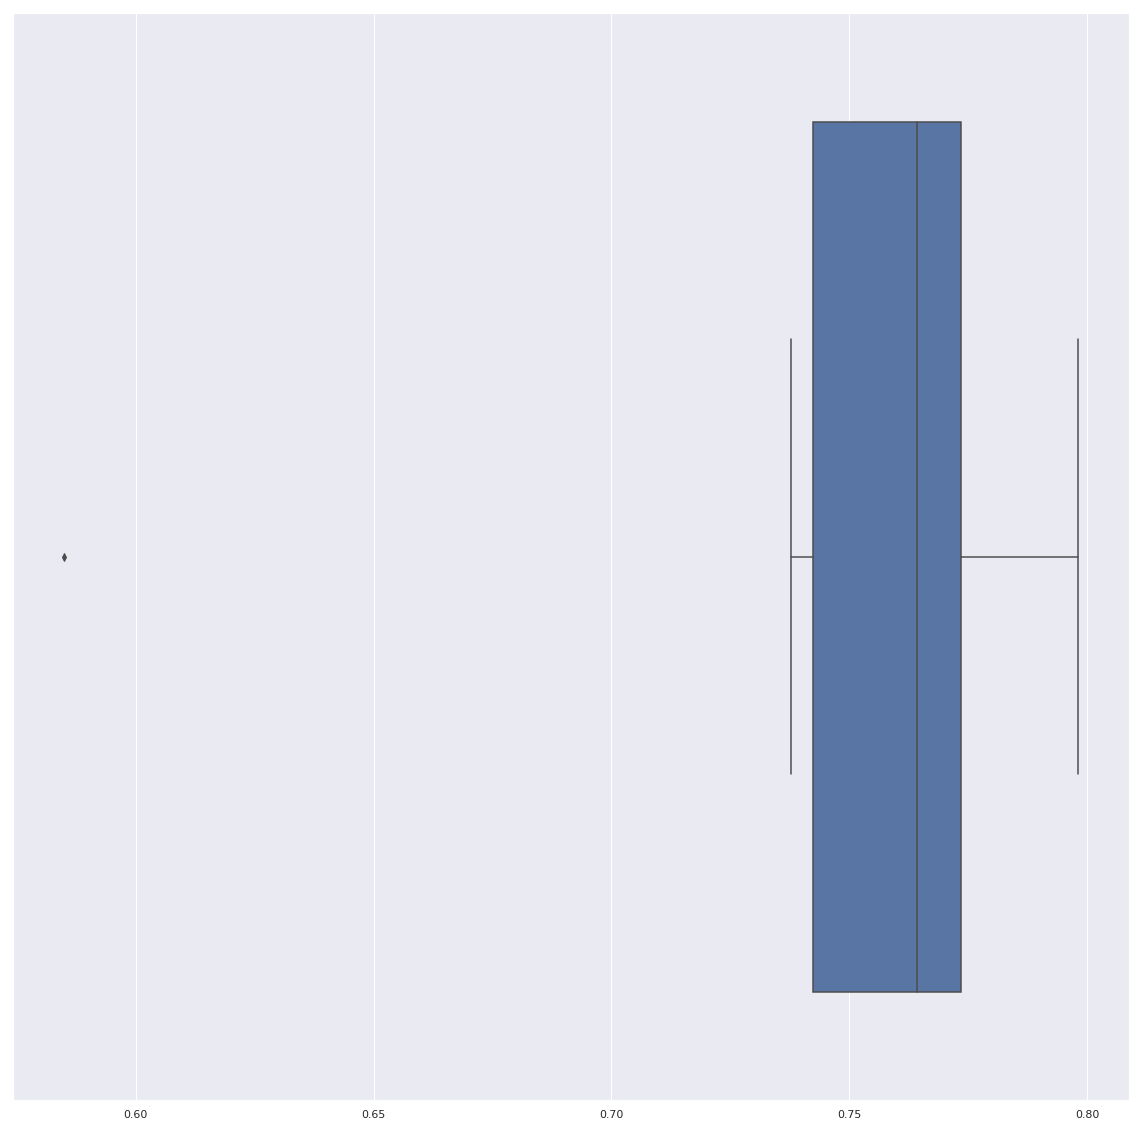

In [70]:
sns.boxplot(accuracy_scores)

### Get feature importances

In [26]:
feat_imp_df = pd.DataFrame(data = feat_imp_dict)
feat_imp_df.head()

,round1,round2,round3,round4,round5,round6,round7,round8,round9,round10
0,0.037558,0.036259,0.036951,0.038627,0.037392,0.036019,0.034469,0.036183,0.036147,0.035723
1,0.058738,0.059138,0.059962,0.064399,0.059453,0.056956,0.065212,0.059580,0.057014,0.056315
2,0.063139,0.067926,0.065946,0.065568,0.061573,0.067574,0.065732,0.063737,0.066773,0.069560
3,0.056783,0.059090,0.060462,0.058856,0.057360,0.059899,0.059234,0.056331,0.055116,0.054774
4,0.056216,0.058592,0.057575,0.056566,0.057684,0.058361,0.056995,0.058815,0.061285,0.058985


In [40]:
feat_imp_df_final = pd.concat([feat_imp_df, pd.Series(my_data[best_feats].columns.values)], axis = 1)
feat_imp_df_final.rename(columns = {0:'element'}, inplace = True )
feat_imp_df_final.head()

,round1,round2,round3,round4,round5,round6,round7,round8,round9,round10,element
0,0.037558,0.036259,0.036951,0.038627,0.037392,0.036019,0.034469,0.036183,0.036147,0.035723,Zr90
1,0.058738,0.059138,0.059962,0.064399,0.059453,0.056956,0.065212,0.059580,0.057014,0.056315,Nd146
2,0.063139,0.067926,0.065946,0.065568,0.061573,0.067574,0.065732,0.063737,0.066773,0.069560,Ba137
3,0.056783,0.059090,0.060462,0.058856,0.057360,0.059899,0.059234,0.056331,0.055116,0.054774,Sr88
4,0.056216,0.058592,0.057575,0.056566,0.057684,0.058361,0.056995,0.058815,0.061285,0.058985,Rb85


In [41]:
feat_imp_df_final.set_index('element', inplace=True)


In [42]:
feat_imp_df_final_plot = feat_imp_df_final.T

In [43]:
feat_imp_df_final_plot

elements = feat_imp_df_final_plot.columns.values 
mean_feature_importance = []
for col in list(feat_imp_df_final_plot.columns.values):
    mean_feature_importance.append(feat_imp_df_final_plot[col].mean())
    

In [44]:
mean_feature_importance_df = pd.concat([pd.Series(elements), pd.Series(mean_feature_importance)], axis = 1)

In [45]:
mean_feature_importance_df.rename(columns={0:'elements', 1:'mean_importance'}, inplace=True)

In [46]:
mean_feature_importance_df.sort_values(by='mean_importance', ascending=False, inplace=True)

In [47]:
ordered_col_names = list(mean_feature_importance_df['elements'])

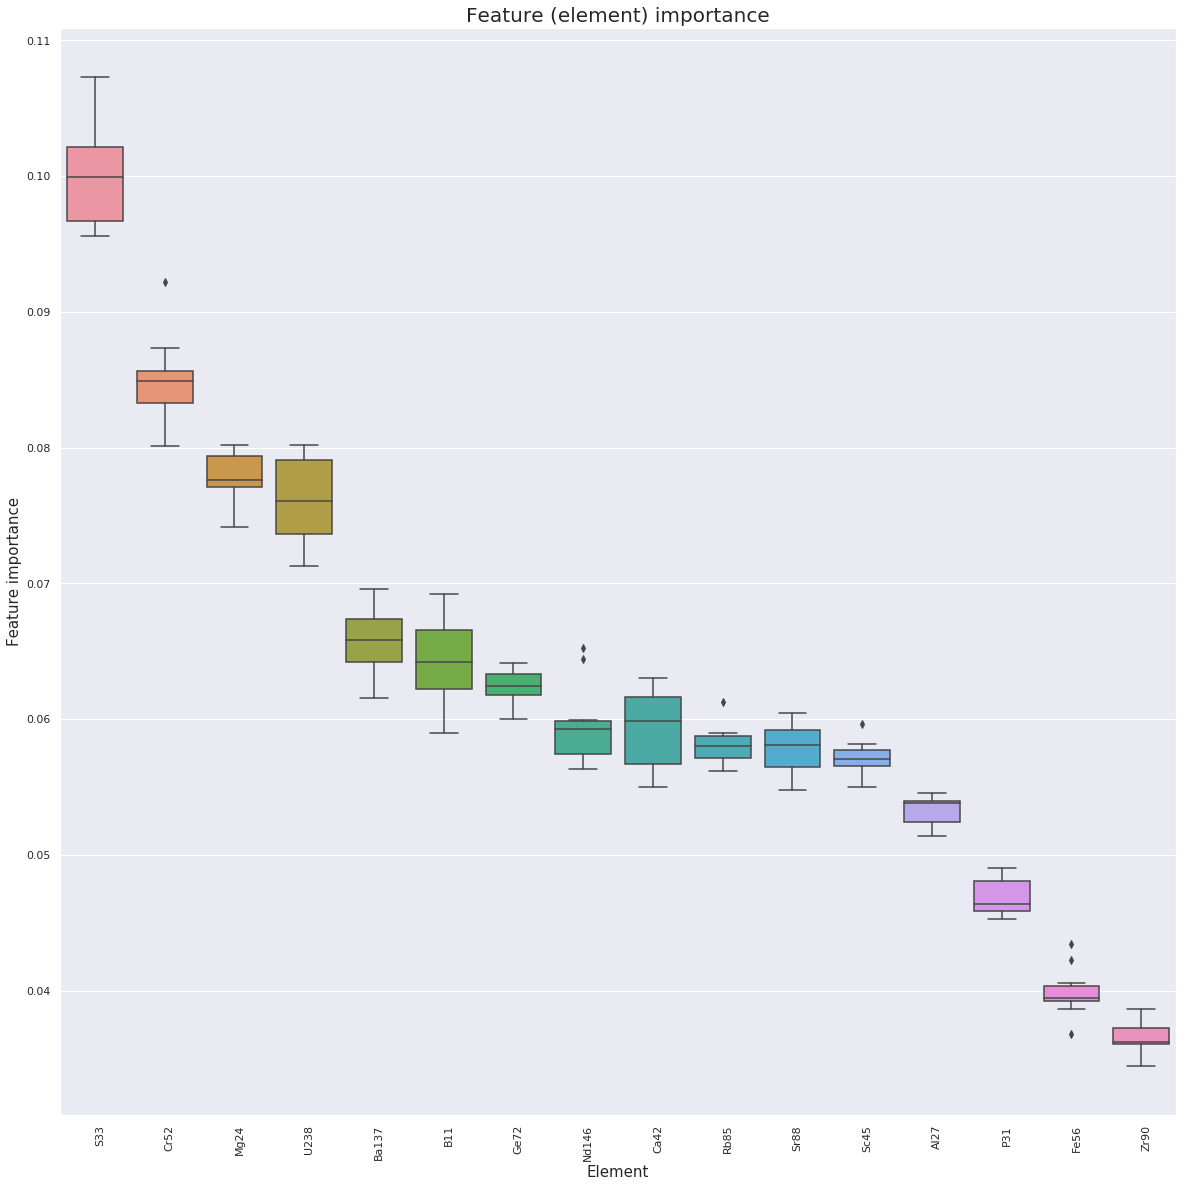

In [48]:
sns.set_style("whitegrid")
sns.set_style()
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.boxplot(data = feat_imp_df_final_plot[ordered_col_names])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
plot.set_xlabel("Element", fontdict={'fontsize': 15})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('feature_importances.png')

### Model is built for predicting source of artefacts 

In [49]:
esti_final = RandomForestClassifier(n_estimators=2000, random_state = random_seed_state)

In [50]:
esti_final.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [52]:
print(train_data_formodel['class'].unique())
print(uniques)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Index(['FH', 'ER', 'WW', 'TC', 'CS', 'KQ', 'AR', 'SL', 'FG', 'WB', 'BX', 'PF',
       'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', 'AB', 'LV', 'SE', 'BA', 'SV', 'WA',
       'MM'],
      dtype='object')


In [53]:
identifiers =  X_test_labeled_df['Analysis']

### Predictions are made for the artefacts

In [54]:
X_test_labeled_df.columns.values[1:-1]

array(['Zr90', 'Nd146', 'Ba137', 'Sr88', 'Rb85', 'Ge72', 'Fe56', 'Cr52',
       'Sc45', 'U238', 'Ca42', 'B11', 'S33', 'P31', 'Mg24', 'Al27'],
      dtype=object)

In [55]:
y_pred = esti_final.predict(np.array(X_test_labeled_df[X_test_labeled_df.columns.values[1:-1]]))

y_pred_proba = esti_final.predict_proba(np.array(X_test_labeled_df[X_test_labeled_df.columns.values[1:-1]]))


In [56]:
probabilities_df = pd.DataFrame(data = y_pred_proba, columns = uniques)
probabilities_df_final = pd.concat([probabilities_df, identifiers], axis = 1)

In [57]:
probabilities_df_final.head()

,FH,ER,WW,TC,CS,KQ,AR,SL,FG,WB,BX,PF,WH,SQ,WN,BH,PH,LB,AB,LV,SE,BA,SV,WA,MM,Analysis
0,0.0025,0.0080,0.005,0.0335,0.0060,0.0510,0.0080,0.013,0.0095,0.0075,0.0015,0.0010,0.0030,0.0170,0.0070,0.0170,0.1010,0.0235,0.0710,0.0670,0.0645,0.1455,0.1555,0.1190,0.0625,06_DH1_1
1,0.0015,0.0060,0.003,0.0275,0.0070,0.0680,0.0110,0.011,0.0100,0.0055,0.0015,0.0025,0.0010,0.0175,0.0065,0.0390,0.1110,0.0230,0.0630,0.0650,0.0745,0.1785,0.1170,0.1035,0.0460,07_DH1_2
2,0.0035,0.0115,0.010,0.0330,0.0060,0.0520,0.0070,0.008,0.0070,0.0090,0.0005,0.0010,0.0025,0.0145,0.0070,0.0295,0.0765,0.0135,0.0695,0.0690,0.0465,0.1510,0.2135,0.0875,0.0710,08_DH1_3
3,0.0175,0.0225,0.069,0.0115,0.0005,0.0335,0.0020,0.006,0.0200,0.0020,0.0015,0.0105,0.0000,0.0030,0.0045,0.0100,0.0375,0.0060,0.0365,0.0405,0.0205,0.2060,0.2290,0.1405,0.0695,09_DH2_1
4,0.0230,0.0150,0.026,0.0145,0.0000,0.0175,0.0025,0.012,0.0105,0.0045,0.0015,0.0085,0.0005,0.0035,0.0065,0.0125,0.0715,0.0080,0.0335,0.0490,0.0350,0.2150,0.1365,0.2150,0.0780,10_DH2_2


In [58]:
final_pred_df = pd.concat([pd.Series(y_pred), probabilities_df_final], axis = 1).rename(columns={0:'class_number'})

In [59]:
final_pred_df.head()

,class_number,FH,ER,WW,TC,CS,KQ,AR,SL,FG,WB,BX,PF,WH,SQ,WN,BH,PH,LB,AB,LV,SE,BA,SV,WA,MM,Analysis
0,22,0.0025,0.0080,0.005,0.0335,0.0060,0.0510,0.0080,0.013,0.0095,0.0075,0.0015,0.0010,0.0030,0.0170,0.0070,0.0170,0.1010,0.0235,0.0710,0.0670,0.0645,0.1455,0.1555,0.1190,0.0625,06_DH1_1
1,21,0.0015,0.0060,0.003,0.0275,0.0070,0.0680,0.0110,0.011,0.0100,0.0055,0.0015,0.0025,0.0010,0.0175,0.0065,0.0390,0.1110,0.0230,0.0630,0.0650,0.0745,0.1785,0.1170,0.1035,0.0460,07_DH1_2
2,22,0.0035,0.0115,0.010,0.0330,0.0060,0.0520,0.0070,0.008,0.0070,0.0090,0.0005,0.0010,0.0025,0.0145,0.0070,0.0295,0.0765,0.0135,0.0695,0.0690,0.0465,0.1510,0.2135,0.0875,0.0710,08_DH1_3
3,22,0.0175,0.0225,0.069,0.0115,0.0005,0.0335,0.0020,0.006,0.0200,0.0020,0.0015,0.0105,0.0000,0.0030,0.0045,0.0100,0.0375,0.0060,0.0365,0.0405,0.0205,0.2060,0.2290,0.1405,0.0695,09_DH2_1
4,21,0.0230,0.0150,0.026,0.0145,0.0000,0.0175,0.0025,0.012,0.0105,0.0045,0.0015,0.0085,0.0005,0.0035,0.0065,0.0125,0.0715,0.0080,0.0335,0.0490,0.0350,0.2150,0.1365,0.2150,0.0780,10_DH2_2


### labels outputted by local outlier factor model are appended to predictions

In [60]:
final_predictions_df = pd.concat([final_pred_df, X_test_labeled_df['inlierLabel']], axis = 1)

In [61]:
final_predictions_df.head()

,class_number,FH,ER,WW,TC,CS,KQ,AR,SL,FG,WB,BX,PF,WH,SQ,WN,BH,PH,LB,AB,LV,SE,BA,SV,WA,MM,Analysis,inlierLabel
0,22,0.0025,0.0080,0.005,0.0335,0.0060,0.0510,0.0080,0.013,0.0095,0.0075,0.0015,0.0010,0.0030,0.0170,0.0070,0.0170,0.1010,0.0235,0.0710,0.0670,0.0645,0.1455,0.1555,0.1190,0.0625,06_DH1_1,1
1,21,0.0015,0.0060,0.003,0.0275,0.0070,0.0680,0.0110,0.011,0.0100,0.0055,0.0015,0.0025,0.0010,0.0175,0.0065,0.0390,0.1110,0.0230,0.0630,0.0650,0.0745,0.1785,0.1170,0.1035,0.0460,07_DH1_2,1
2,22,0.0035,0.0115,0.010,0.0330,0.0060,0.0520,0.0070,0.008,0.0070,0.0090,0.0005,0.0010,0.0025,0.0145,0.0070,0.0295,0.0765,0.0135,0.0695,0.0690,0.0465,0.1510,0.2135,0.0875,0.0710,08_DH1_3,1
3,22,0.0175,0.0225,0.069,0.0115,0.0005,0.0335,0.0020,0.006,0.0200,0.0020,0.0015,0.0105,0.0000,0.0030,0.0045,0.0100,0.0375,0.0060,0.0365,0.0405,0.0205,0.2060,0.2290,0.1405,0.0695,09_DH2_1,1
4,21,0.0230,0.0150,0.026,0.0145,0.0000,0.0175,0.0025,0.012,0.0105,0.0045,0.0015,0.0085,0.0005,0.0035,0.0065,0.0125,0.0715,0.0080,0.0335,0.0490,0.0350,0.2150,0.1365,0.2150,0.0780,10_DH2_2,1


In [62]:
uniques_list = list(uniques)
def get_pred_names(row):
    return(uniques_list[row['class_number']])
final_predictions_df['class_predictions'] = final_predictions_df.apply(get_pred_names, axis = 1)

In [63]:
final_predictions_df.head()

,class_number,FH,ER,WW,TC,CS,KQ,AR,SL,FG,WB,BX,PF,WH,SQ,WN,BH,PH,LB,AB,LV,SE,BA,SV,WA,MM,Analysis,inlierLabel,class_predictions
0,22,0.0025,0.0080,0.005,0.0335,0.0060,0.0510,0.0080,0.013,0.0095,0.0075,0.0015,0.0010,0.0030,0.0170,0.0070,0.0170,0.1010,0.0235,0.0710,0.0670,0.0645,0.1455,0.1555,0.1190,0.0625,06_DH1_1,1,SV
1,21,0.0015,0.0060,0.003,0.0275,0.0070,0.0680,0.0110,0.011,0.0100,0.0055,0.0015,0.0025,0.0010,0.0175,0.0065,0.0390,0.1110,0.0230,0.0630,0.0650,0.0745,0.1785,0.1170,0.1035,0.0460,07_DH1_2,1,BA
2,22,0.0035,0.0115,0.010,0.0330,0.0060,0.0520,0.0070,0.008,0.0070,0.0090,0.0005,0.0010,0.0025,0.0145,0.0070,0.0295,0.0765,0.0135,0.0695,0.0690,0.0465,0.1510,0.2135,0.0875,0.0710,08_DH1_3,1,SV
3,22,0.0175,0.0225,0.069,0.0115,0.0005,0.0335,0.0020,0.006,0.0200,0.0020,0.0015,0.0105,0.0000,0.0030,0.0045,0.0100,0.0375,0.0060,0.0365,0.0405,0.0205,0.2060,0.2290,0.1405,0.0695,09_DH2_1,1,SV
4,21,0.0230,0.0150,0.026,0.0145,0.0000,0.0175,0.0025,0.012,0.0105,0.0045,0.0015,0.0085,0.0005,0.0035,0.0065,0.0125,0.0715,0.0080,0.0335,0.0490,0.0350,0.2150,0.1365,0.2150,0.0780,10_DH2_2,1,BA


### final predictions including assignments from local outlier factor model are added

In [64]:
def outlierAssigner(row):
    if row['inlierLabel'] == -1:
        return('other')
    else:
        return(row['class_predictions'])
    
final_predictions_df['class_predictions'] = final_predictions_df.swifter.apply(outlierAssigner, axis = 1)

Pandas Apply: 100%|██████████| 363/363 [00:00<00:00, 26948.91it/s]


In [65]:
final_predictions_df.head()

,class_number,FH,ER,WW,TC,CS,KQ,AR,SL,FG,WB,BX,PF,WH,SQ,WN,BH,PH,LB,AB,LV,SE,BA,SV,WA,MM,Analysis,inlierLabel,class_predictions
0,22,0.0025,0.0080,0.005,0.0335,0.0060,0.0510,0.0080,0.013,0.0095,0.0075,0.0015,0.0010,0.0030,0.0170,0.0070,0.0170,0.1010,0.0235,0.0710,0.0670,0.0645,0.1455,0.1555,0.1190,0.0625,06_DH1_1,1,SV
1,21,0.0015,0.0060,0.003,0.0275,0.0070,0.0680,0.0110,0.011,0.0100,0.0055,0.0015,0.0025,0.0010,0.0175,0.0065,0.0390,0.1110,0.0230,0.0630,0.0650,0.0745,0.1785,0.1170,0.1035,0.0460,07_DH1_2,1,BA
2,22,0.0035,0.0115,0.010,0.0330,0.0060,0.0520,0.0070,0.008,0.0070,0.0090,0.0005,0.0010,0.0025,0.0145,0.0070,0.0295,0.0765,0.0135,0.0695,0.0690,0.0465,0.1510,0.2135,0.0875,0.0710,08_DH1_3,1,SV
3,22,0.0175,0.0225,0.069,0.0115,0.0005,0.0335,0.0020,0.006,0.0200,0.0020,0.0015,0.0105,0.0000,0.0030,0.0045,0.0100,0.0375,0.0060,0.0365,0.0405,0.0205,0.2060,0.2290,0.1405,0.0695,09_DH2_1,1,SV
4,21,0.0230,0.0150,0.026,0.0145,0.0000,0.0175,0.0025,0.012,0.0105,0.0045,0.0015,0.0085,0.0005,0.0035,0.0065,0.0125,0.0715,0.0080,0.0335,0.0490,0.0350,0.2150,0.1365,0.2150,0.0780,10_DH2_2,1,BA


### predictions are stored as a variable into memory

In [66]:
%store final_predictions_df

Stored 'final_predictions_df' (DataFrame)


### predictions are outputted as csv file

In [73]:
if save_predictions:
    final_predictions_df.to_csv('predictions.csv')
